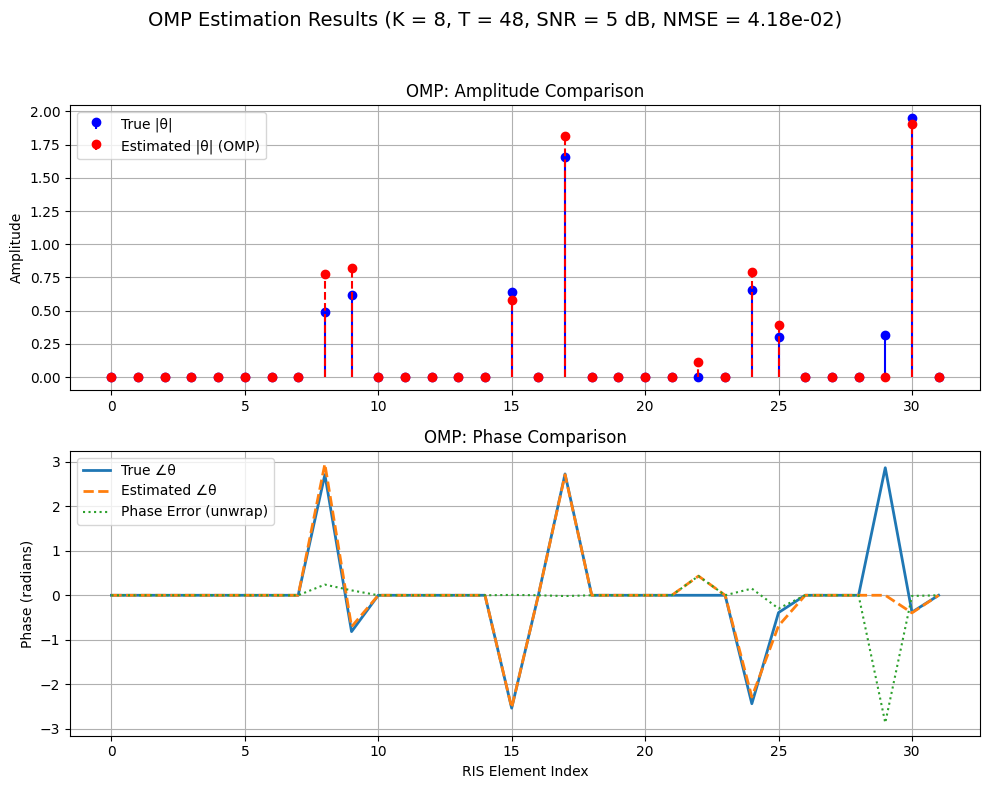

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Step 1: OMP Implementation
# ----------------------------
def omp(y, A, K, tol=1e-6):
    T, N = A.shape
    r = y.copy()
    S = []
    theta_hat = np.zeros((N, 1), dtype=complex)

    for _ in range(K):
        correlations = np.abs(A.conj().T @ r).flatten()
        j = np.argmax(correlations)
        if j not in S:
            S.append(j)

        A_S = A[:, S]
        theta_S, _, _, _ = np.linalg.lstsq(A_S, y, rcond=None)
        r = y - A_S @ theta_S

        if np.linalg.norm(r) < tol:
            break

    for idx, val in zip(S, theta_S):
        theta_hat[idx] = val

    return theta_hat

# ----------------------------
# Step 2: System Parameters
# ----------------------------
M = 4
N = 32
K = 8                 # True sparsity level
T = int(1.5 * N)      # Reduce measurement time for difficulty
SNR_dB = 5            # Lower SNR to induce noise
sigma2 = 1 / (10**(SNR_dB / 10))

# ----------------------------
# Step 3: Generate Sparse True Channel
# ----------------------------
np.random.seed(42)
theta_true = np.zeros((N, 1), dtype=complex)
nonzero_indices = np.random.choice(N, K, replace=False)
theta_true[nonzero_indices] = (np.random.randn(K, 1) + 1j * np.random.randn(K, 1)) / np.sqrt(2)

# ----------------------------
# Step 4: Generate Pilot and Measurements
# ----------------------------
X = (np.random.randn(M, T) + 1j * np.random.randn(M, T)) / np.sqrt(2)
Phi = np.exp(1j * 2 * np.pi * np.random.rand(N, T))
H1 = (np.random.randn(N, M) + 1j * np.random.randn(N, M)) / np.sqrt(2)

y = np.zeros((T, 1), dtype=complex)
A = np.zeros((T, N), dtype=complex)

for t in range(T):
    x_t = X[:, t].reshape(M, 1)
    phi_t = Phi[:, t].reshape(N, 1)
    Hx = H1 @ x_t
    a_t = (phi_t.flatten() * Hx.flatten()).T
    A[t, :] = a_t

    # Stronger noise injected
    noise = 2 * np.sqrt(sigma2 / 2) * (np.random.randn() + 1j * np.random.randn())
    y[t] = A[t, :] @ theta_true + noise

# ----------------------------
# Step 5: Run OMP Estimation
# ----------------------------
theta_est = omp(y, A, K)
nmse = np.linalg.norm(theta_est - theta_true)**2 / np.linalg.norm(theta_true)**2

# ----------------------------
# Step 6: Plot Results
# ----------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Amplitude Comparison
axs[0].stem(np.abs(theta_true), linefmt='b-', markerfmt='bo', basefmt=" ", label='True |θ|')
axs[0].stem(np.abs(theta_est), linefmt='r--', markerfmt='ro', basefmt=" ", label='Estimated |θ| (OMP)')
axs[0].set_title("OMP: Amplitude Comparison")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True)
axs[0].legend()

# Phase Comparison
true_phase = np.angle(theta_true)
est_phase = np.angle(theta_est)
phase_error = np.unwrap(est_phase - true_phase)

axs[1].plot(true_phase, label="True ∠θ", linewidth=2)
axs[1].plot(est_phase, '--', label="Estimated ∠θ", linewidth=2)
axs[1].plot(phase_error, ':', label="Phase Error (unwrap)", linewidth=1.5)
axs[1].set_title("OMP: Phase Comparison")
axs[1].set_xlabel("RIS Element Index")
axs[1].set_ylabel("Phase (radians)")
axs[1].grid(True)
axs[1].legend()

plt.suptitle(f"OMP Estimation Results (K = {K}, T = {T}, SNR = {SNR_dB} dB, NMSE = {nmse:.2e})", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
